
# Flower Classification using CNN

## Isha Sharma, Lei Chan, Kandace Richards

### 1. Introduction

There are millions of beautiful flowers bursting around every corner, & we've been constantly awed by the beauty & uniqueness of each flower. Classifiying different flowers from one another is indeed a challenging task, as there're a plethora of flowers to classify & flowers can appear similar to each other. However, classifiying different flowers species will be advantageous in the fields such as the pharmaceutical industry, botany, agricultural, & trade activities, which is why we thought of performing this task.

The main aim of this project is to solve a Supervised Image Classification problem of classifying the flower types - rose, chamomile, dandelion, sunflower, & tulip. In the end, we’ll have a trained model, which can predict the class of the flower using a Machine Learning algorithm, the Convolutional Neural Networks (CNN).

### 2. Source

The dataset used for this project was the Flowers Recognition dataset from Kaggle, which consists of 5 classes of flower species - rose, chamomile, dandelion, sunflower, & tulip, each having about 800 images. So, we’ve a total of 4242 images to train our model with.

### 3. Procedure

#### 3.1 Importing Libraries

This code should only run once for the entire project because its purpose is to extract data and convert it into an npz file for use during the program. Once the npz file has been created, it does not need to be created multiple times since we hold a reference to these files.

Initally, the following libraries were imported to use in the data conversion process:

In [1]:
# Used for manipulating directory paths
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path

# Data visualisation 
import pandas as pd 
import seaborn as sns

# Image manipulation
from PIL import Image
from skimage.io import imread
import cv2

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np 

# Plotting library
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# dl libraries specifically for CNN
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras import layers
from keras import models
from keras import optimizers

# Tells matplotlib to embed plots within the notebook
%matplotlib inline

import math

#### 3.2 Reading the Dataset
After importing the libraries, we began importing the flower data, using the os & pandas modules. We also, extracted & plotted few sample of different flowers for some visualisation.

In [2]:
# Dataset folder
flowersPath = Path('flowersData')

# Each species of flower is contained in a separate folder, & this is to get all the sub-directories
flowers = os.listdir(flowersPath)
print("Number of types of flowers: ", len(flowers))
print("Types of flowers: ", flowers)

# A list which contains tuples, the type of flower and the corresponding image path
flowersList = []

for species in flowers:
    # Get all the file names
    allFlowers = os.listdir(flowersPath / species)
    # Add them to the list
    for flower in allFlowers:
        flowersList.append((species, str(flowersPath /species) + '/' + flower))

# Build a dataframe        
flowersList = pd.DataFrame(data=flowersList, columns=['category', 'image'], index=None)
flowersList.head()

Number of types of flowers:  5
Types of flowers:  ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


,category,image
0,daisy,flowersData/daisy/14167534527_781ceb1b7a_n.jpg
1,daisy,flowersData/daisy/34718882165_68cdc9def9_n.jpg
2,daisy,flowersData/daisy/5512287917_9f5d3f0f98_n.jpg
3,daisy,flowersData/daisy/476857510_d2b30175de_n.jpg
4,daisy,flowersData/daisy/521762040_f26f2e08dd.jpg


Total number of flowers in the dataset:  4326
Flowers in each category: 
dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64


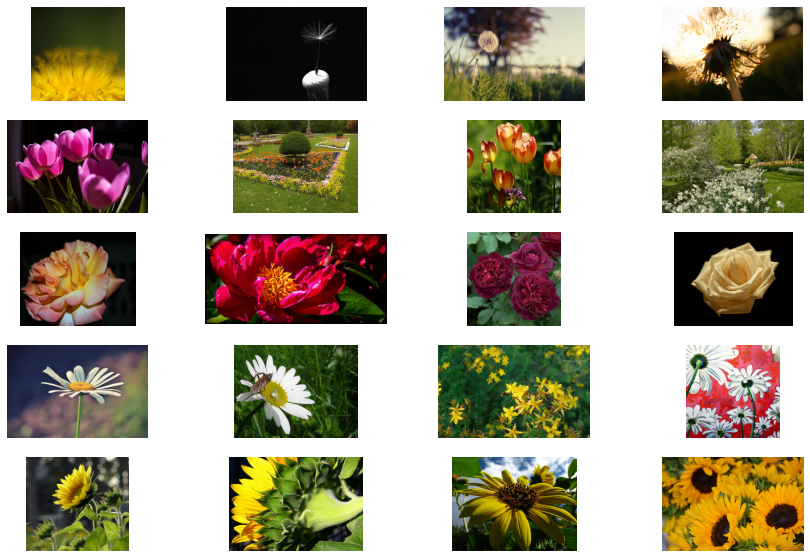

In [3]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowersList))
flowerNum = flowersList['category'].value_counts()
print("Flowers in each category: ")
print(flowerNum)

# A list for storing names of some random samples from each category
RanSamples = []

# Get samples fom each category 
for category in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(RanSamples):
    ax[i//4, i%4].imshow(mimg.imread(RanSamples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

This snippet is to visualise how many samples we've for each flower type in the bar chart.

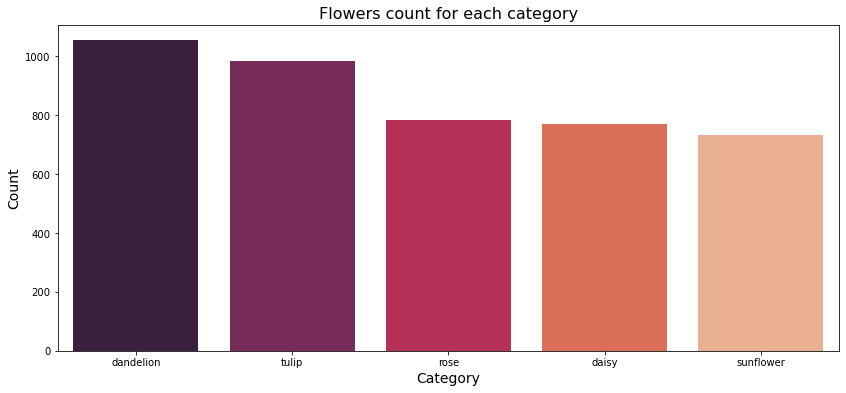

In [4]:
# Let's do some visualization and see how many samples we have for each category
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

After extracting all of the flower data from the file, we converted image to pixels & printed them out for all the random sampled images.

In [5]:
# convert image to pixels, print the pixels
def convert_pix_matrix(imageUrl):
    pix_val = imread(imageUrl)
    return pix_val

def heightWidth(imageUrl,heightWidth):
    im = Image.open(imageUrl)
    h, w = im.size
    if (heightWidth == "width"):
        return w
    else:
        return h
    
# first example from rand sample
print("image width: ", heightWidth(RanSamples[0],"width"))
print("image height: ", heightWidth(RanSamples[0],"height"))
print(convert_pix_matrix(RanSamples[0]))

# read the pixels and conver back to image
def readPixel(pixel):
    img = Image.fromarray(pixel)
    img.save('readPxielExample.png')
    img.show()
    
readPixel(convert_pix_matrix(RanSamples[1]))

image width:  240
image height:  240
[[[ 21  25  10]
  [ 20  24   9]
  [ 20  24   9]
  ...
  [ 43  45  21]
  [ 43  45  21]
  [ 43  45  21]]

 [[ 20  24   9]
  [ 20  24   9]
  [ 20  24   9]
  ...
  [ 43  45  21]
  [ 43  45  21]
  [ 43  45  21]]

 [[ 20  24   9]
  [ 20  24   9]
  [ 20  24   9]
  ...
  [ 43  45  21]
  [ 43  45  21]
  [ 43  45  21]]

 ...

 [[234 195   2]
  [236 197   4]
  [238 202   6]
  ...
  [163 115   5]
  [160 112   2]
  [158 112   0]]

 [[236 198   1]
  [237 201   1]
  [240 205   2]
  ...
  [161 113   2]
  [159 111   0]
  [157 111   0]]

 [[237 199   0]
  [239 204   1]
  [243 208   4]
  ...
  [158 111   0]
  [157 109   0]
  [156 110   0]]]


### What is Neural Network?

A Neural network is basically a system of softwares patterned after the working of neurons in the human brain. Just like how human brain has interconnected neurons that process information, a Neural Network also has interconnected artificial neurons called as nodes that takes some input, processes those inputs in layers to produce the output. A neural network has basically 3 layers:

1. Input Layer : This layer accepts input in the form of array of numbers.
2. Hidden Layers : This layer performs some calculations on the given input & does feature extraction on the data to locate patterns. There are weights assigned in each layer whose weighted sum is calculated with the inputs & a bias is added. Weights are basically random values that are assigned between each node in the network. Different activation functions are applied to the hidden layers for extracting specific features. A network can contain multiple hidden layers.
3. Output Layer : This layer produces the desired output after a number of iterations.

This is a visual representaion of what a Neural Network looks like.

 <img src="images/Untitled_Artwork2.png" width="800" height="400">

 ### Why the Convolutional Neural Network (CNN) for image classification?

Convolutional Neural Network is one of the classes of the deep learning Neural Networks. They’re most commonly used to analyze visual imagery & are frequently working behind the scenes in image classification. They can be found at the core of everything from Facebook’s photo tagging to self-driving cars. They’re now a crucial part of a lot of sectors from healthcare to security.

Image classification is the process of taking an input (like a picture) & outputting a class (like rose or tulip) or a probability that the input is a particular class (“there’s a 90% probability that this input is a rose”).

CNNs have an input layer, and output layer, and hidden layers. The hidden layers usually consist of convolutional layers, ReLU layers, pooling layers, and fully connected layers.
- Convolutional layers : Convolution layer applies a convolution operation to the input for passing the result to the next layer. Each convolution processes the data only for its respective field.

- Activation Function layers: It is used to determine the output of a neural network (like rose/tulip). It can also be attached between two different neural networks. The activation functions could be Sigmoid, RELU, softmax etc..

- Pooling layers : It is responsible for reducing the spatial size of the convoluted feature. Pooling combines the output of neuron cluster at one layer into a single neuron in the next layer.

- Fully connected layer : It connects every neuron in one layer to every neuron in the next layer.

In a convolutional layer, neurons only receive input from a subarea of the previous layer. In a fully connected layer, each neuron receives input from every element of the previous layer.

A classic CNN architecture would look something like this:

 <img src="images/Untitled_Artwork3.png" width="800" height="100">

CNNs have an input layer, and output layer, and hidden layers. The hidden layers usually consist of convolutional layers, ReLU layers, pooling layers, and fully connected layers.
 - Convolutional layers apply a convolution operation to the input. This passes the information on to the next layer.
 - Pooling combines the outputs of clusters of neurons into a single neuron in the next layer.
 - Fully connected layers connect every neuron in one layer to every neuron in the next layer.
In a convolutional layer, neurons only receive input from a subarea of the previous layer. In a fully connected layer, each neuron receives input from every element of the previous layer.


 



#### 3.2 Creating Training & Validation sets of the data

After importing the libraries, we began importing the flower data, using the os & pandas modules. We also, extracted & plotted few sample of different flowers for some visualisation.

In [6]:
# image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

# train_dataset = image_generator.flow_from_directory(batch_size=32,
#                                                  directory='flowersData',
#                                                  shuffle=True,
#                                                  target_size=(280, 280), 
#                                                  subset="training",
#                                                  class_mode='categorical')

# validation_dataset = image_generator.flow_from_directory(batch_size=32,
#                                                  directory='flowersData',
#                                                  shuffle=True,
#                                                  target_size=(280, 280), 
#                                                  subset="validation",
#                                                  class_mode='categorical')


# For creating parent directory `test` & 2 sub directories `validationSet` & `trainingSet` with all flower data separate
# test set
# %mkdir -p test/trainingSet/daisy
# %mkdir -p test/trainingSet/tulip
# %mkdir -p test/trainingSet/sunflower
# %mkdir -p test/trainingSet/rose
# %mkdir -p test/trainingSet/dandelion
# # valid set 
# %mkdir -p test/validationSet/daisy
# %mkdir -p test/validationSet/tulip
# %mkdir -p test/validationSet/sunflower
# %mkdir -p test/validationSet/rose
# %mkdir -p test/validationSet/dandelion
#for going back to the working directory
# %cd .. 

# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/dandelion
%mkdir -p train/rose
%mkdir -p train/sunflower
%mkdir -p train/tulip

%mkdir -p valid/daisy
%mkdir -p valid/dandelion
%mkdir -p valid/rose
%mkdir -p valid/sunflower
%mkdir -p valid/tulip

%cd ..

/Users/ishasharma/MLProject/data
/Users/ishasharma/MLProject


In [7]:
# for copying 100 samples to the validation dir & others to the train dir
for category in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == category].values
    diffPics = np.random.permutation(samples)
    for i in range(100):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(101,len(diffPics)):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'./data/train/' + str(category) + '/' + name)
        
